# Backtest: AI Mega‑Cap + Crypto Thesis (Oct 1, 2024 → Oct 1, 2025)

This notebook backtests three contribution strategies on your thesis portfolio:

**Portfolio Weights**
- 25% NVDA (AI chips, Mag7)  
- 10% AMZN (hyperscaler, Mag7)  
- 10% GOOGL (hyperscaler, Mag7)  
- 10% MSFT (hyperscaler, Mag7)  
- 10% AAPL (devices ecosystem)  
- 15% ETH‑USD (stable‑coin rails, B2B settlement)  
- 20% BTC‑USD (store of value / treasury asset)

**Date range:** 2024‑10‑01 to 2025‑10‑01 (inclusive of contributions; last valuation on 2025‑10‑01)

**Strategies**
1. **DCA only**: DCA the \$20,000 evenly over 12 months **plus** \$2,500 each month.  
2. **Lump + DCA**: Lump sum \$20,000 on start date **plus** \$2,500 each month.  
3. **Limit‑Order DCA (10% dip rule)**: Same monthly total as Strategy #1, but each month you place a “limit” at 10% below the month’s opening price for each asset. The purchase executes on the **first day** that closes ≤ 90% of that month’s opening price; if no such day occurs, buy on the month’s final trading day.

> Notes:
> - Prices are Yahoo Finance daily closes (auto‑adjusted).  
> - Stocks trade weekdays; BTC/ETH trade 7 days. Each month’s purchases occur on the applicable asset’s first/last **available** trading day in that month.
> - This is educational code, not investment advice.


In [1]:
# Install packages if needed (uncomment if running in a clean environment)
# %pip install yfinance pandas numpy matplotlib python-dateutil


In [2]:
import math
from dataclasses import dataclass
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.4f}'.format


## Parameters (edit me)


In [3]:
START_DATE = "2024-10-01"
END_DATE   = "2025-10-01"   # last day for valuation; contributions run through 12 months ending Sep-2025

# Monthly contributions
INITIAL_TOTAL = 20_000.00
EXTRA_MONTHLY = 2_500.00

# Portfolio weights (must sum to 1.0)
WEIGHTS = {
    "NVDA": 0.25,
    "AMZN": 0.10,
    "GOOGL": 0.10,
    "MSFT": 0.10,
    "AAPL": 0.10,
    "ETH-USD": 0.15,
    "BTC-USD": 0.20,
}

assert abs(sum(WEIGHTS.values()) - 1.0) < 1e-9, "Weights must sum to 1.0"
TICKERS = list(WEIGHTS.keys())

# For Strategy 1 (DCA only): spread the initial 20k evenly over 12 months
MONTHS = 12
DCA_ONLY_MONTHLY = INITIAL_TOTAL / MONTHS + EXTRA_MONTHLY  # $1,666.67 + $2,500 = $4,166.67

# For Strategy 2 (Lump + DCA): buy $20k on START_DATE; add $2,500 monthly
LUMP_SUM = INITIAL_TOTAL
LUMP_DCA_MONTHLY = EXTRA_MONTHLY

# For Strategy 3 (Limit-Order DCA): same monthly total as Strategy 1, but with 10% dip rule
LIMIT_DCA_MONTHLY = DCA_ONLY_MONTHLY
LIMIT_DIP_THRESHOLD = 0.10  # 10% below month open


## Download daily prices from Yahoo Finance


In [4]:
def download_prices(tickers, start, end):
    data = yf.download(
        tickers=tickers,
        start=start,
        end=(pd.to_datetime(end) + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
        interval="1d",
        auto_adjust=True,
        group_by="ticker",
        progress=False,
        threads=True,
    )
    # Normalize to a MultiIndex with (ticker, field)
    if isinstance(data.columns, pd.MultiIndex):
        # Keep only 'Close'
        closes = {}
        for t in tickers:
            if (t, 'Close') in data.columns:
                closes[t] = data[(t, 'Close')].rename(t)
            else:
                # Some single-ticker downloads can be flat; handle robustly
                if 'Close' in data.columns:
                    closes[t] = data['Close'].rename(t)
        df_close = pd.concat(closes.values(), axis=1)
    else:
        # Single-ticker path
        df_close = data['Close'].to_frame(tickers[0])
    return df_close.sort_index()

prices = download_prices(TICKERS, START_DATE, END_DATE)
prices.tail()


,NVDA,AMZN,GOOGL,MSFT,AAPL,ETH-USD,BTC-USD
Date,,,,,,,
2025-09-27,NaN,NaN,NaN,NaN,NaN,"4,018.6582","109,681.9453"
2025-09-28,NaN,NaN,NaN,NaN,NaN,"4,141.4766","112,122.6406"
2025-09-29,181.8500,222.1700,244.0500,514.6000,254.4300,"4,217.3418","114,400.3828"
2025-09-30,186.5800,219.5700,243.1000,517.9500,254.6300,"4,145.9575","114,056.0859"
2025-10-01,187.2400,220.6300,244.9000,519.7100,255.4500,"4,351.1123","118,648.9297"


## Helper utilities

We’ll:
- build a month schedule (Oct 2024 → Sep 2025),
- pick per‑asset first/last trading day within each month,
- and execute contributions per strategy with precise execution dates.


In [6]:
def month_range(start_date, months=12):
    start = pd.to_datetime(start_date)
    months_list = []
    cur = start
    for _ in range(months):
        months_list.append((cur.replace(day=1), (cur.replace(day=1) + relativedelta(months=1)) - pd.Timedelta(days=1)))
        cur = cur + relativedelta(months=1)
    return months_list

def first_trading_day_in_month(prices_series, month_start, month_end):
    sub = prices_series.loc[(prices_series.index >= month_start) & (prices_series.index <= month_end)]
    if sub.empty:
        return None
    return sub.index[0]

def last_trading_day_in_month(prices_series, month_start, month_end):
    sub = prices_series.loc[(prices_series.index >= month_start) & (prices_series.index <= month_end)]
    if sub.empty:
        return None
    return sub.index[-1]


## Strategy Engines


In [19]:
@dataclass
class Trade:
    date: pd.Timestamp
    ticker: str
    amount_usd: float
    price: float
    shares: float
    strategy: str

def execute_monthly_dca(prices, weights, months_list, monthly_amount, strategy_name):
    """Buy on the last trading day of each month for each asset."""
    trades = []
    for (m_start, m_end) in months_list:
        for t, w in weights.items():
            series = prices[t].dropna()
            buy_day = last_trading_day_in_month(series, m_start, m_end)
            if buy_day is None:
                continue
            amt = monthly_amount * w
            px = float(series.loc[buy_day])
            sh = 0.0 if px == 0 else amt / px
            trades.append(Trade(buy_day, t, amt, px, sh, strategy_name))
    return trades

def execute_lump_then_dca(prices, weights, start_date, months_list, lump_amount, monthly_amount, strategy_name):
    trades = []

    # Lump on first trading day for each asset
    start = pd.to_datetime(start_date)
    for t, w in weights.items():
        series = prices[t].dropna()
        first_day = series.loc[series.index >= start]
        if first_day.empty:
            continue
        first_day = first_day.index[0]
        amt = lump_amount * w
        px = float(series.loc[first_day])
        sh = 0.0 if px == 0 else amt / px
        trades.append(Trade(first_day, t, amt, px, sh, strategy_name))

    # Then monthly DCA on last trading day
    trades.extend(execute_monthly_dca(prices, weights, months_list, monthly_amount, strategy_name))
    return trades

def execute_limit_order_dca(prices, weights, months_list, monthly_amount, stock_dip=0.05, crypto_dip=0.10, strategy_name="Limit_DCA_varied"):
    """
    For each month & asset:
    - For stocks:  buy if a close <= (1 - stock_dip) * month_open
    - For crypto:  buy if a close <= (1 - crypto_dip) * month_open
    - Otherwise, buy on the last trading day.
    """
    trades = []
    for (m_start, m_end) in months_list:
        for t, w in weights.items():
            series = prices[t].dropna()
            sub = series.loc[(series.index >= m_start) & (series.index <= m_end)]
            if sub.empty:
                continue

            month_open = float(sub.iloc[0])
            # choose dip threshold based on asset type
            if "USD" in t:        # crypto tickers like BTC-USD, ETH-USD
                limit_price = (1.0 - crypto_dip) * month_open
            else:                 # stocks
                limit_price = (1.0 - stock_dip) * month_open

            # Find the first close <= limit
            hit_idx = None
            for dt, px in sub.items():
                if px <= limit_price:
                    hit_idx = dt
                    break

            buy_day = hit_idx if hit_idx is not None else sub.index[-1]
            amt = monthly_amount * w
            px = float(series.loc[buy_day])
            sh = 0.0 if px == 0 else amt / px
            trades.append(Trade(buy_day, t, amt, px, sh, strategy_name))
    return trades



## Run the three strategies


In [20]:
months_list = month_range(START_DATE, months=12)

# Strategy 1: DCA only (20k over 12 months + 2.5k monthly)
trades_s1 = execute_monthly_dca(prices, WEIGHTS, months_list, DCA_ONLY_MONTHLY, "DCA_only")

# Strategy 2: Lump + DCA (20k lump on start + 2.5k monthly)
trades_s2 = execute_lump_then_dca(prices, WEIGHTS, START_DATE, months_list, LUMP_SUM, LUMP_DCA_MONTHLY, "Lump_then_DCA")

# Strategy 3: Limit-Order DCA (same monthly total as S1, 10% dip rule)
trades_s3 = execute_limit_order_dca(
    prices, WEIGHTS, months_list, LIMIT_DCA_MONTHLY,
    stock_dip=0.05, crypto_dip=0.10, strategy_name="Limit_DCA_stocks5_crypto10"
)

len(trades_s1), len(trades_s2), len(trades_s3)


(84, 91, 84)

## Build position histories and portfolio equity curves


In [22]:
def trades_to_dataframe(trades):
    return pd.DataFrame([{
        "date": t.date,
        "ticker": t.ticker,
        "amount_usd": t.amount_usd,
        "price": t.price,
        "shares": t.shares,
        "strategy": t.strategy
    } for t in trades]).sort_values(["date", "ticker"]).reset_index(drop=True)

df_s1 = trades_to_dataframe(trades_s1)
df_s2 = trades_to_dataframe(trades_s2)
df_s3 = trades_to_dataframe(trades_s3)

def holdings_over_time(prices, trades_df):
    # cumulative shares per ticker over time
    all_days = prices.index
    tickers = trades_df["ticker"].unique().tolist()
    share_df = pd.DataFrame(0.0, index=all_days, columns=tickers)

    for t in tickers:
        t_tr = trades_df.loc[trades_df["ticker"] == t, ["date", "shares"]].copy()
        t_tr = t_tr.groupby("date")["shares"].sum().sort_index()
        # align to all_days
        s = pd.Series(0.0, index=all_days)
        s.loc[t_tr.index] = t_tr.values
        share_df[t] = s.cumsum()

    # portfolio value = sum(shares * price) across tickers
    value_df = (share_df * prices[tickers]).sum(axis=1).to_frame("portfolio_value")
    return share_df, value_df

shares_s1, equity_s1 = holdings_over_time(prices, df_s1)
shares_s2, equity_s2 = holdings_over_time(prices, df_s2)
shares_s3, equity_s3 = holdings_over_time(prices, df_s3)

equity = pd.concat([
    equity_s1.rename(columns={"portfolio_value": "DCA_only"}),
    equity_s2.rename(columns={"portfolio_value": "Lump_then_DCA"}),
    equity_s3.rename(columns={"portfolio_value": "Limit_DCA_10pct"}),
], axis=1)
equity = equity.dropna(how="all")
equity.tail()


,DCA_only,Lump_then_DCA,Limit_DCA_10pct
Date,,,
2025-09-27,"20,987.7796","24,727.1695","21,888.8286"
2025-09-28,"21,540.7809","25,369.9007","22,467.9147"
2025-09-29,"59,354.3538","66,135.1040","60,684.2761"
2025-09-30,"63,666.4068","68,792.7514","64,363.5172"
2025-10-01,"64,877.8902","70,149.9706","65,590.1595"


## Summaries


In [23]:
def cash_invested(trades_df):
    return trades_df["amount_usd"].sum()

def final_value_on(equity_series, end_date):
    end_ts = pd.to_datetime(end_date)
    sub = equity_series.loc[equity_series.index <= end_ts]
    if sub.empty:
        return np.nan
    return float(sub.iloc[-1])

summary_rows = []
for name, df_tr, eq in [
    ("DCA_only", df_s1, equity["DCA_only"]),
    ("Lump_then_DCA", df_s2, equity["Lump_then_DCA"]),
    ("Limit_DCA_10pct", df_s3, equity["Limit_DCA_10pct"]),
]:
    invested = cash_invested(df_tr)
    fv = final_value_on(eq, END_DATE)
    pl = fv - invested
    ret = np.nan if invested == 0 else pl / invested
    summary_rows.append({
        "strategy": name,
        "total_invested": invested,
        "final_value": fv,
        "profit_loss": pl,
        "return_pct": ret * 100.0,
    })

summary_df = pd.DataFrame(summary_rows).set_index("strategy").round(2)
summary_df


,total_invested,final_value,profit_loss,return_pct
strategy,,,,
DCA_only,"50,000.0000","64,877.8900","14,877.8900",29.7600
Lump_then_DCA,"50,000.0000","70,149.9700","20,149.9700",40.3000
Limit_DCA_10pct,"50,000.0000","65,590.1600","15,590.1600",31.1800


### Per‑asset share counts & cost basis (by strategy)


In [24]:
def per_asset_summary(prices, trades_df, end_date):
    end_ts = pd.to_datetime(end_date)
    last_prices = prices.loc[prices.index <= end_ts].iloc[-1]
    g = trades_df.groupby("ticker").agg(
        invested_usd=("amount_usd", "sum"),
        shares=("shares", "sum")
    )
    g["last_price"] = g.index.map(lambda t: float(last_prices.get(t, np.nan)))
    g["final_value"] = g["shares"] * g["last_price"]
    g["p_l"] = g["final_value"] - g["invested_usd"]
    g["return_%"] = np.where(g["invested_usd"]>0, (g["p_l"]/g["invested_usd"])*100, np.nan)
    return g.round(4)

per_asset_s1 = per_asset_summary(prices, df_s1, END_DATE)
per_asset_s2 = per_asset_summary(prices, df_s2, END_DATE)
per_asset_s3 = per_asset_summary(prices, df_s3, END_DATE)

per_asset_s1


,invested_usd,shares,last_price,final_value,p_l,return_%
ticker,,,,,,
AAPL,"5,000.0000",22.1804,255.4500,"5,665.9848",665.9848,13.3197
AMZN,"5,000.0000",23.7326,220.6300,"5,236.1175",236.1175,4.7223
BTC-USD,"10,000.0000",0.1043,"118,648.9297","12,378.6080","2,378.6080",23.7861
ETH-USD,"7,500.0000",2.7253,"4,351.1123","11,857.9016","4,357.9016",58.1054
GOOGL,"5,000.0000",27.6082,244.9000,"6,761.2410","1,761.2410",35.2248
MSFT,"5,000.0000",11.4054,519.7100,"5,927.4879",927.4879,18.5498
NVDA,"12,500.0000",91.0625,187.2400,"17,050.5495","4,550.5495",36.4044


## Charts


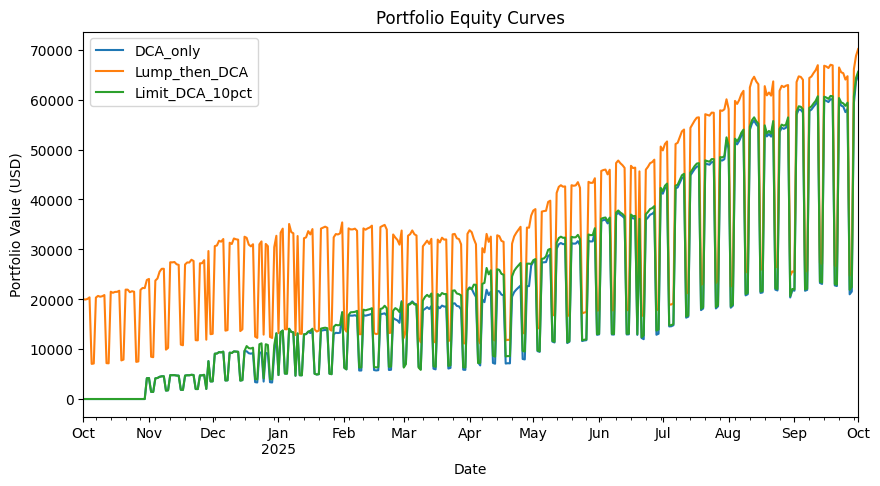

In [25]:
# Equity curve
plt.figure(figsize=(10,5))
equity.plot(ax=plt.gca())
plt.title("Portfolio Equity Curves")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.show()


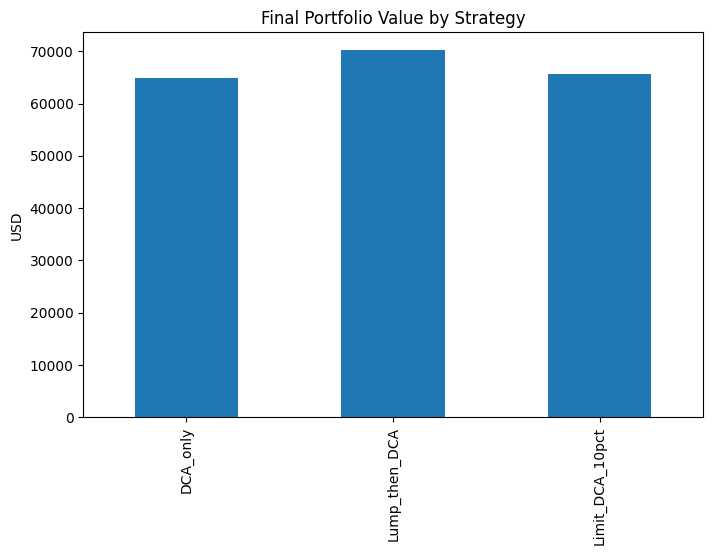

In [27]:
# Bar chart of final value by strategy
finals = pd.Series({
    "DCA_only": final_value_on(equity["DCA_only"], END_DATE),
    "Lump_then_DCA": final_value_on(equity["Lump_then_DCA"], END_DATE),
    "Limit_DCA_10pct": final_value_on(equity["Limit_DCA_10pct"], END_DATE),
})
plt.figure(figsize=(8,5))
finals.plot(kind="bar")
plt.title("Final Portfolio Value by Strategy")
plt.ylabel("USD")
plt.show()


## Inspect trades
Use these to see exactly when each purchase occurred and at what price.


In [28]:
df_s1.head(10)


,date,ticker,amount_usd,price,shares,strategy
0,2024-10-31,AAPL,416.6667,224.8635,1.8530,DCA_only
1,2024-10-31,AMZN,416.6667,186.4000,2.2353,DCA_only
2,2024-10-31,BTC-USD,833.3333,"70,215.1875",0.0119,DCA_only
3,2024-10-31,ETH-USD,625.0000,"2,515.7993",0.2484,DCA_only
4,2024-10-31,GOOGL,416.6667,170.3587,2.4458,DCA_only
5,2024-10-31,MSFT,416.6667,403.3221,1.0331,DCA_only
6,2024-10-31,NVDA,"1,041.6667",132.7219,7.8485,DCA_only
7,2024-11-29,AAPL,416.6667,236.4905,1.7619,DCA_only
8,2024-11-29,AMZN,416.6667,207.8900,2.0043,DCA_only
9,2024-11-29,GOOGL,416.6667,168.2082,2.4771,DCA_only


In [29]:
df_s2.head(10)


,date,ticker,amount_usd,price,shares,strategy
0,2024-10-01,AAPL,"2,000.0000",225.1621,8.8825,Lump_then_DCA
1,2024-10-01,AMZN,"2,000.0000",185.1300,10.8032,Lump_then_DCA
2,2024-10-01,BTC-USD,"4,000.0000","60,837.0078",0.0657,Lump_then_DCA
3,2024-10-01,ETH-USD,"3,000.0000","2,448.9211",1.2250,Lump_then_DCA
4,2024-10-01,GOOGL,"2,000.0000",166.2568,12.0296,Lump_then_DCA
5,2024-10-01,MSFT,"2,000.0000",417.5552,4.7898,Lump_then_DCA
6,2024-10-01,NVDA,"5,000.0000",116.9665,42.7473,Lump_then_DCA
7,2024-10-31,AAPL,250.0000,224.8635,1.1118,Lump_then_DCA
8,2024-10-31,AMZN,250.0000,186.4000,1.3412,Lump_then_DCA
9,2024-10-31,BTC-USD,500.0000,"70,215.1875",0.0071,Lump_then_DCA


In [30]:
df_s3.head(10)


,date,ticker,amount_usd,price,shares,strategy
0,2024-10-31,AAPL,416.6667,224.8635,1.8530,Limit_DCA_stocks5_crypto10
1,2024-10-31,AMZN,416.6667,186.4000,2.2353,Limit_DCA_stocks5_crypto10
2,2024-10-31,BTC-USD,833.3333,"70,215.1875",0.0119,Limit_DCA_stocks5_crypto10
3,2024-10-31,ETH-USD,625.0000,"2,515.7993",0.2484,Limit_DCA_stocks5_crypto10
4,2024-10-31,GOOGL,416.6667,170.3587,2.4458,Limit_DCA_stocks5_crypto10
5,2024-10-31,MSFT,416.6667,403.3221,1.0331,Limit_DCA_stocks5_crypto10
6,2024-10-31,NVDA,"1,041.6667",132.7219,7.8485,Limit_DCA_stocks5_crypto10
7,2024-11-29,AAPL,416.6667,236.4905,1.7619,Limit_DCA_stocks5_crypto10
8,2024-11-29,AMZN,416.6667,207.8900,2.0043,Limit_DCA_stocks5_crypto10
9,2024-11-29,GOOGL,416.6667,168.2082,2.4771,Limit_DCA_stocks5_crypto10


## Export trades & summaries (CSV)


In [31]:
import os

outdir = "exports"
os.makedirs(outdir, exist_ok=True)

df_s1.to_csv(f"{outdir}/trades_strategy1_dca_only.csv", index=False)
df_s2.to_csv(f"{outdir}/trades_strategy2_lump_then_dca.csv", index=False)
df_s3.to_csv(f"{outdir}/trades_strategy3_limit_dca_10pct.csv", index=False)

summary_df.to_csv(f"{outdir}/summary_by_strategy.csv")
per_asset_s1.to_csv(f"{outdir}/per_asset_summary_strategy1.csv")
per_asset_s2.to_csv(f"{outdir}/per_asset_summary_strategy2.csv")
per_asset_s3.to_csv(f"{outdir}/per_asset_summary_strategy3.csv")

exports = os.listdir(outdir)
exports


['per_asset_summary_strategy1.csv',
 'per_asset_summary_strategy2.csv',
 'per_asset_summary_strategy3.csv',
 'summary_by_strategy.csv',
 'trades_strategy1_dca_only.csv',
 'trades_strategy2_lump_then_dca.csv',
 'trades_strategy3_limit_dca_10pct.csv']